In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
from torchvision import datasets
from torchvision import transforms

# transform data into tensors
transform = transforms.ToTensor()

train_data = datasets.SVHN(root = './data', split='train', download=True, transform=transform)

batch_size = 128
num_workers = 0

# train loaders
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size,shuffle=True, num_workers=num_workers)

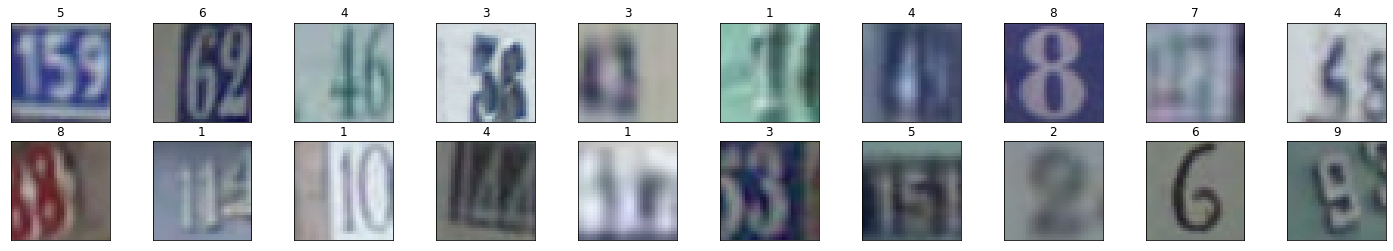

In [3]:
# visualizing images
images, labels = next(iter(train_loader))

# plot images in the batch alongside with the labels
fig = plt.figure(figsize=(25,4))
plot_size = 20  # 20 images

for i in range(plot_size):
  ax = fig.add_subplot(2, plot_size/2, i+1, xticks=[], yticks=[])
  ax.imshow(np.transpose(images[i], (1,2,0)))
  # printing labels
  ax.set_title(str(labels[i].item()))

In [4]:
img = images[0]
print('Scaled min', img.min())
print('Scaled max', img.max())

Scaled min tensor(0.1373)
Scaled max tensor(0.8196)


In [5]:
def scale(x, feature_range=(-1,1)):
  '''takes an image input (that has a float pixels value between 
  0 to 1 and outputs the image pixels in the range -2 to 1'''
  # x = x*(max - min) + min
  return x*(feature_range[1]-feature_range[0]) + feature_range[0]

In [6]:
# test scale function
scaled_img = scale(img)

print('Scaled min', scaled_img.min())
print('Scaled max', scaled_img.max())

Scaled min tensor(-0.7255)
Scaled max tensor(0.6392)


### Building the Discriminator

In [7]:
import torch.nn
import torch.functional as F

def conv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  '''
  Creates a convolutional layer with optional batch normalization.
  '''
  conv_layers = nn.Conv2d(in_channels, out_channels, 
                          kernel_size, stride, padding, bias = False)
  
  # append conv layers
  layers = [conv_layers]

  if batch_norm:
    #append a batchnorm layer
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [8]:
class Discriminator(nn.Module):

  def __init__(self, conv_dim=32):
    super(Discriminator, self).__init__()
    self.conv_dim = conv_dim

    # 32x32 in to conv1
    self.conv1 = conv(3, self.conv_dim, 4, batch_norm=False)
    # 16x16 out from conv1 --> in to conv2
    self.conv2 = conv(self.conv_dim, self.conv_dim*2, 4)
    # 8x8 out from conv2 --> in to conv3
    self.conv3 = conv(self.conv_dim*2, self.conv_dim*4, 4)
    # 4x4 out from conv3 --> in to fc layer

    # fully-connected layer
    self.fc = nn.Linear(conv_dim*4*4*4, 1)

  def forward(self, x):
    lrelu_slope = 0.2
    out = F.leaky_relu(self.conv1(x), lrelu_slope)
    out = F.leaky_relu(self.conv2(out), lrelu_slope)
    out = F.leaky_relu(self.conv3(out), lrelu_slope)
    
    # reshape to fc input
    out = out.view(-1, self.conv_dim*4*4*4)
    # output
    out = self.fc(out)
    return out

In [9]:
import torch.nn
import torch.nn.functional as F

def deconv(in_channels, out_channels, kernel_size, stride=2, padding=1, batch_norm=True):
  '''
  Creates a convolutional layer with optional batch normalization.
  '''
  transpose_convs = nn.ConvTranspose2d(in_channels, out_channels, 
                          kernel_size, stride, padding, bias = False)
  
  # append conv layers
  layers = [transpose_convs]

  if batch_norm:
    #append a batchnorm layer
    layers.append(nn.BatchNorm2d(out_channels))
  
  return nn.Sequential(*layers)

In [16]:
class Generator(nn.Module):

  def __init__(self, z_size, conv_dim=32):
    super(Generator, self).__init__()
    self.conv_dim = conv_dim
    self.z_size = z_size
    # fc layer
    self.fc = nn.Linear(self.z_size, conv_dim*4*4*4)

    # 4x4 in from input --> to deconv1
    self.deconv1 = deconv(self.conv_dim*4, self.conv_dim*2, 4)
    # 8x8 in from deconv1 --> to deconv2
    self.deconv2 = deconv(self.conv_dim*2, self.conv_dim, 4)
    # 16x16 in from deconv2 --> to deconv3
    self.deconv3 = deconv(self.conv_dim, 3, 4, batch_norm = False)
    # 32x32 in from deconv3 --> to out

    # tanh
    self.tanh = nn.Tanh()

  def forward(self, x):
    # Latent vector z is the input
    out = self.fc(x)
    out = out.view(-1, self.conv_dim*4,4,4) # (batch_size, depth, image_width, image_height)  # that are 4x4 
    out = F.relu(self.deconv1(out))
    out = F.relu(self.deconv2(out))
    out = self.tanh(self.deconv3(out))

    return out

In [17]:
# define hyperparameters
conv_dim = 32
z_size = 150

# define discriminator and generator
D = Discriminator(conv_dim)
G = Generator(z_size=z_size, conv_dim=conv_dim)

print(D,'\n')
print(G)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
) 

Generator(
  (fc): Linear(in_features=150, out_features=2048, bias=True)
  (deconv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (deconv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bia

In [18]:
# set training on GPU if available
train_on_gpu = torch.cuda.is_available()
device = 'cuda' if train_on_gpu else 'cpu'
if train_on_gpu:
  print("GPU available --> make necessary measures while training")
else:
  print("GPU is not available --> training on CPU")

G.to(device)
D.to(device);

GPU available --> make necessary measures while training


In [20]:
def real_loss(d_out, smooth=False):
  batch_size = d_out.shape[0]
  labels = torch.ones(batch_size)
  # label smoothining
  if smooth:
    labels = torch.ones(batch_size)*0.9
  labels = labels.to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(d_out.squeeze(), labels)
  return loss

def fake_loss(d_out):
  batch_size = d_out.shape[0]
  labels = torch.zeros(batch_size)
  labels = labels.to(device)
  criterion = nn.BCEWithLogitsLoss()
  loss = criterion(d_out.squeeze(), labels)
  return loss

In [21]:
import torch.optim as optim

# params
lr = 2.1e-4
beta1 = 0.5
beta2 = 0.9

# optimizers for the generator and the discriminator
d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

In [23]:
import pickle as pkl
from tqdm import tqdm

# training hyperparameters
epochs = 50
print_every = 300

# keep track of loss and generated samples
samples = []
losses = []

# constant images that are held through out training to keep an eye on the training process and inspect model's performance
sample_size = 16
fixed_z = torch.from_numpy(np.random.uniform(-1,1, size=(sample_size, z_size))).float()

for e in range(epochs):

  for batch_i, (images, _) in enumerate(train_loader):
    # set to training mode
    D.train()
    G.train()

    batch_size = images.shape[0]
    # make sures that gradients are not accumilated
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

    # get the real output
    images = scale(images)

    ### TRAINING DISCRIMINATOR ###
    # train with real images
    # 1. set to train on GPU
    images = images.to(device)

    # 2. get the output of the real images and calcuate the real loss
    d_real = D(images)
    d_real = d_real
    d_real_loss = real_loss(d_real)

    # 3. get the output of the fake images and calculate the fake loss
    # 3.1 preparing z
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    z = z.to(device)
    fake_images = G(z)
    f_fake = D(fake_images)
    d_fake_loss = fake_loss(f_fake)

    # 4. add fake loss and real loss to calculate the total loss and then back propagate
    d_loss = d_real_loss + d_fake_loss
    d_loss.backward()
    d_optimizer.step()

    ### TRAINING GENERATOR ###
    # 1 preparing z
    z = np.random.uniform(-1, 1, size=(batch_size, z_size))
    z = torch.from_numpy(z).float()
    z = z.to(device)

    # 2. feed forward to generator and calculate adverserial real loss
    fake_images = G(z)
    d_fake = D(fake_images)
    g_loss = real_loss(d_fake)
    
    # 3. backpropagate
    g_loss.backward()
    g_optimizer.step()

    # prints to inspect model performance
    if batch_i%print_every == 0:
      # append discriminator and generator loss
      losses.append((d_loss.item(),g_loss.item()))  # (discriminator, generator)
      # print losses
      print(f"Epoch{e+1:5d}/{epochs:5d} | d_loss: {d_loss.item():6.4f} | g_loss: {g_loss.item():6.4f}") 

  ## AFTER EACH EPOCH##    
  # generate and save sample, fake images
  G.eval() # for generating samples
  if train_on_gpu:
      fixed_z = fixed_z.cuda()
  samples_z = G(fixed_z)
  samples.append(samples_z)
  G.train() # back to training mode

  # Save training generator samples
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch    1/   50 | d_loss: 0.6289 | g_loss: 1.8240
Epoch    1/   50 | d_loss: 0.5909 | g_loss: 1.2523
Epoch    2/   50 | d_loss: 0.4855 | g_loss: 2.3289
Epoch    2/   50 | d_loss: 0.2028 | g_loss: 3.3367
Epoch    3/   50 | d_loss: 0.4117 | g_loss: 3.5397
Epoch    3/   50 | d_loss: 0.4067 | g_loss: 4.5671
Epoch    4/   50 | d_loss: 0.2115 | g_loss: 3.2589
Epoch    4/   50 | d_loss: 0.0821 | g_loss: 3.9539
Epoch    5/   50 | d_loss: 0.7637 | g_loss: 5.9948
Epoch    5/   50 | d_loss: 0.0360 | g_loss: 4.9850
Epoch    6/   50 | d_loss: 0.5432 | g_loss: 7.7308
Epoch    6/   50 | d_loss: 0.0687 | g_loss: 4.2410
Epoch    7/   50 | d_loss: 0.1314 | g_loss: 4.5604
Epoch    7/   50 | d_loss: 0.2291 | g_loss: 5.0207
Epoch    8/   50 | d_loss: 0.5769 | g_loss: 7.1583
Epoch    8/   50 | d_loss: 0.0446 | g_loss: 4.7355
Epoch    9/   50 | d_loss: 0.1318 | g_loss: 5.2949
Epoch    9/   50 | d_loss: 0.0346 | g_loss: 3.7669
Epoch   10/   50 | d_loss: 0.8489 | g_loss: 7.8197
Epoch   10/   50 | d_loss: 0.09

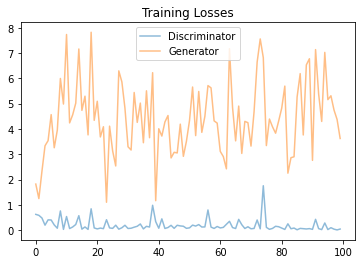

In [26]:
# Train loss
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [27]:
# helper function for viewing a list of passed in sample images
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach().cpu().numpy()
        img = np.transpose(img, (1, 2, 0))
        img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((32,32,3)))

### Generated Samples

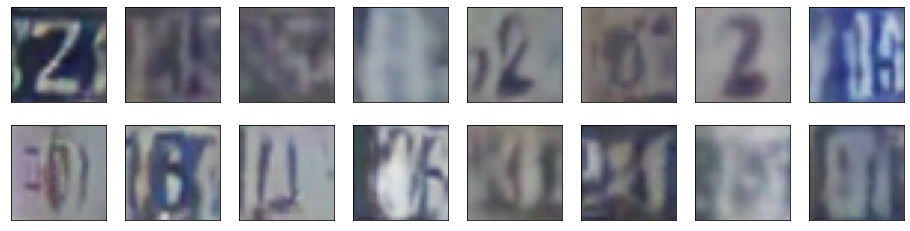

In [28]:
view_samples(-1, samples);